In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
previsoes_np = pd.DataFrame(pd.read_csv('Resultados/Resultados_Demandas_NP').iloc[:,-1])

In [23]:
previsoes_np

,demandas
0,"[10285.419921875, 10280.4609375, 10283.2597656..."
1,"[10277.7685546875, 10275.919921875, 10279.1679..."
2,"[10288.455078125, 10284.46875, 10297.29296875,..."
3,"[10283.1181640625, 10274.01171875, 10269.40625..."
4,"[10288.53125, 10281.18359375, 10287.076171875,..."
5,"[10279.34375, 10273.6884765625, 10274.27539062..."
6,"[10276.642578125, 10279.3134765625, 10273.8740..."
7,"[10287.873046875, 10275.3623046875, 10285.4833..."
8,"[10281.7109375, 10281.169921875, 10283.6796875..."
9,"[10275.439453125, 10277.23046875, 10286.352539..."


In [39]:
resultados_dataframe_1 = {}

coluna_aux = []
for element in range(len(previsoes_np)):
    #para cada linha, do data frame, que esta como string, em vez d vetor, vou separar por virgula os valores de -1 a 1,
    #posição, pois no começo e no final, tem os caracteres [], e para cada elemento, coloco ele em um vetor
    coluna_aux.append([float(elemento) for elemento in previsoes_np.iloc[element,0][1:-1].split(',')])
    
resultados_dataframe_1['demandas'] = coluna_aux

resultados_dataframe_1 = pd.DataFrame(resultados_dataframe_1)

In [50]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(len(dataframe.iloc[0,0])):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

In [65]:
def describe_var_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(6,3))

    plt.plot(range(len(describe1_var.columns)),describe1_var.iloc[1,:],color='blue',label='Floresta Aleatória')
    plt.plot(range(len(describe2_var.columns)),describe2_var.iloc[1,:],color='red',label='Rede Neural')

    plt.xlabel(var)
    plt.ylabel('Valor Médio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Imgs\{var}Medio.png', format='png')
    plt.show()

In [70]:
def describe_var_desv_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(6,3))

    plt.plot(range(len(describe1_var.columns)),describe1_var.iloc[2,:],color='blue',label='Floresta Aleatória')
    plt.plot(range(len(describe2_var.columns)),describe2_var.iloc[2,:],color='red',label='Rede Neural')

    plt.xlabel(var)
    plt.ylabel('Desvio Padrão')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Imgs\{var}FrdvioPadrao.png', format='png')
    plt.show()

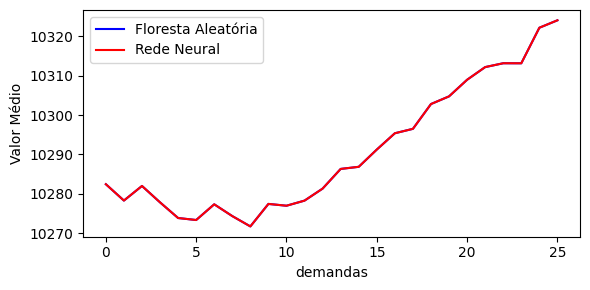

In [66]:
describe1 = describe_var(resultados_dataframe_1,'demandas').describe()
describe_var_grafico(describe1,describe1,'demandas')

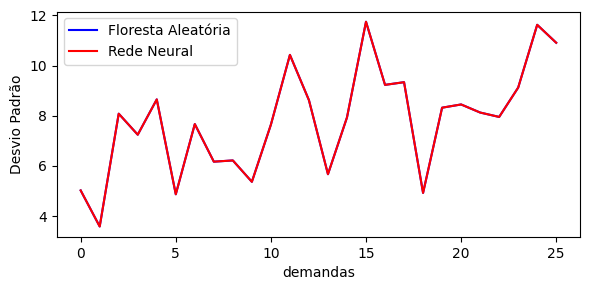

In [71]:
describe_var_desv_grafico(describe1,describe1,'demandas')